In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
import numpy as np


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
%matplotlib inline

from math import sqrt
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Analysis imports
from pandas.plotting import lag_plot
from pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas import DataFrame
from pandas import concat

# Modelling imports
from statsmodels.tsa.arima_model import ARIMA
from fbprophet import Prophet
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
from keras.layers import Dropout
from keras.preprocessing.sequence import TimeseriesGenerator
from keras.layers.core import Activation
import tensorflow as tf
from keras.initializers import glorot_uniform

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split

import random
from numpy.random import seed

import statsmodels.api as sm
import itertools
import warnings
warnings.filterwarnings('ignore')

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
dff = pd.read_csv('/content/drive/MyDrive/busybee/one_year_occupancy.txt', delimiter = "\t")

In [ ]:
df_room1=dff[dff['area_id'] == 'f5017bd4-085c-4efb-a38e-389f4ee42d82']

In [ ]:
df_room1.shape

(278015, 4)

In [ ]:
df=df_room1

In [ ]:
import datetime as dt

df['timestamp'] = pd.to_datetime(df['timestamp'])
df["year"] = df["timestamp"].dt.year
df["month"] = df["timestamp"].dt.month
df["day"] = df["timestamp"].dt.day
df["hour"] = df["timestamp"].dt.hour
df["minute"] = df["timestamp"].dt.minute
df["second"] = df["timestamp"].dt.second
df['weekday'] = df[['timestamp']].apply(lambda x: dt.datetime.strftime(x['timestamp'], '%A'), axis=1)

In [ ]:
df_room1.head()
df_room1.drop('area_id', axis=1, inplace=True)
df_room1.drop('year', axis=1, inplace=True)
df_room1.drop('month', axis=1, inplace=True)
df_room1.drop('day', axis=1, inplace=True)
df_room1.drop('hour', axis=1, inplace=True)
df_room1.drop('minute', axis=1, inplace=True)
df_room1.drop('second', axis=1, inplace=True)
df_room1.drop('weekday', axis=1, inplace=True)

In [ ]:
df_room1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 278015 entries, 0 to 380686
Data columns (total 3 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   id         278015 non-null  int64         
 1   occupancy  278015 non-null  int64         
 2   timestamp  278015 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2)
memory usage: 8.5 MB


In [ ]:
indexedDataset = df_room1.set_index(['timestamp'])

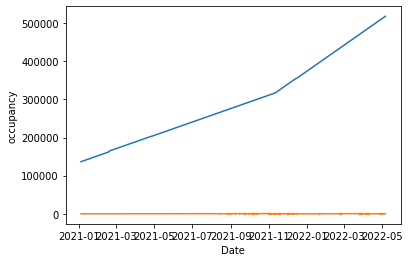

In [ ]:
## plot graph
plt.xlabel('Date')
plt.ylabel('occupancy')
plt.plot(indexedDataset)

In [ ]:
def show_graph(train, test=None, pred=None, title=None):
    
    fig = plt.figure(figsize=(20, 5))

    # entire data
    ax1 = fig.add_subplot(121)
    ax1.set_xlabel('Dates')
    ax1.set_ylabel('Price')
    ax1.plot(train.index, train['occupancy'], color='green', label='Train price')
    if test is not None:
        ax1.plot(test.index, test['occupancy'], color='red', label='Test price')
    if pred is not None:
        if 'yhat' in pred.columns:
            ax1.plot(pred.index, pred['yhat'], color = 'blue', label = 'Predicted occupancy')
            ax1.fill_between(pred.index, pred['yhat_lower'], pred['yhat_upper'], color='grey', label="Band Range")
        else:
            ax1.plot(pred.index, pred['Price'], color='blue', label='Predicted occupancy')
    ax1.legend()
    if title is not None:
        plt.title(title + ' (Entire)')
    plt.grid(True)

    # zoom data
    period=50
    period=int(0.2*len(train))
    ax2 = fig.add_subplot(122)
    ax2.set_xlabel('Dates')
    ax2.set_ylabel('occupancy')
    ax2.plot(train.index[-period:], train['occupancy'].tail(period), color='green', label='Train price')
    if test is not None:
        ax2.plot(test.index, test['occupancy'], color='red', label='Test price')
    if pred is not None:
        if 'yhat' in pred.columns:
            ax2.plot(pred.index, pred['yhat'], color = 'blue', label = 'Predicted occupancy')
            ax2.fill_between(pred.index, pred['yhat_lower'], pred['yhat_upper'], color='grey', label="Band Range")
        else:
            ax2.plot(pred.index, pred['occupancy'], color='blue', label='Predicted occupancy')
    ax2.legend()
    if title is not None:
        plt.title(title + ' (Recent ' + str(period) + ')')
    plt.grid(True)

    fig.subplots_adjust(wspace=0.1, hspace=0.1)
    plt.show()
    
def make_future_dates(last_date, period):
    prediction_dates=pd.date_range(last_date, periods=period+1, freq='B')
    return prediction_dates[1:]

def calculate_accuracy(forecast, actual, algorithm):
    mse  = round(mean_squared_error(actual, forecast),4)
    mae  = round(mean_absolute_error(actual, forecast),4)
    rmse = round(sqrt(mean_squared_error(actual, forecast)),4)
    return ({'algorithm':algorithm, 'mse':mse, 'mae':mae, 'rmse': rmse})

In [ ]:
#exp1
#indexedDataset = indexedDataset['2021-10-01':'2022-05-01']

In [ ]:
#exp2
indexedDataset = indexedDataset['2022-1-01':'2022-05-01']

In [ ]:
split = int(0.99*len(indexedDataset))
train_data, test_data = indexedDataset[0:split], indexedDataset[split:]


In [ ]:
train_data.shape 

(68677, 2)

In [ ]:
test_data.shape

(694, 2)

In [ ]:
def set_random_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)

def create_lstm_data(train,test,look_back):
    train_lstm = train
    test_lstm = test
    train_gen = TimeseriesGenerator(train_lstm, train_lstm, length=look_back, batch_size=20)     
    test_gen = TimeseriesGenerator(test_lstm, test_lstm, length=look_back, batch_size=1)
    print("lstm data created")
    return train_gen, test_gen

def create_lstm_model(neurons, activ_func="linear",
                dropout=0.10, loss="mean_squared_error", optimizer="adam"):
    set_random_seed(20200715)
    model = Sequential()
    print("adding layers")
    model.add(LSTM(neurons,
                   input_shape=(look_back,1),
                   kernel_initializer=glorot_uniform(seed=20200715)
                  ))
    model.add(Dropout(dropout))
    model.add(Dense(units=1,
                   kernel_initializer=glorot_uniform(seed=20200715)
                  ))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    print("model created")
    return model

def predict_lstm_model(data, period, model):
    prediction_list = data[-look_back:]
    
    for _ in range(period):
        x = prediction_list[-look_back:]
        x = x.reshape((1, look_back, 1))
        out = model.predict(x)[0][0]
        prediction_list = np.append(prediction_list, out)
        
    prediction_list = prediction_list[look_back-1:]
    prediction_list = prediction_list[1:]
    print("got prediction")
    return prediction_list

def show_lstm_history(history):
    loss = history.history['loss']
    epochs = range(1, len(loss) + 1)
    plt.figure()
    plt.plot(epochs, loss,  label='Training loss')
    plt.title('validation loss')
    plt.legend()
    plt.show()

In [ ]:
# feature Scaling
stdsc = StandardScaler()
train_lstm = stdsc.fit_transform(train_data.values.reshape(-1, 1))
test_lstm = stdsc.transform(test_data.values.reshape(-1, 1))

In [ ]:
# create data
look_back = 7
train_gen, test_gen = create_lstm_data(train_lstm, test_lstm, look_back)

lstm data created


In [ ]:


# create model
model = create_lstm_model(300)
model.summary()

adding layers
model created
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 300)               362400    
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 1)                 301       
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# training
history = model.fit_generator(train_gen, epochs=10, verbose=1, shuffle=False)


Epoch 1/10
6868/6868 [==============================] - 109s 16ms/step - loss: 0.0018
Epoch 2/10
6868/6868 [==============================] - 109s 16ms/step - loss: 7.8796e-04
Epoch 3/10
6868/6868 [==============================] - 121s 18ms/step - loss: 5.5344e-04
Epoch 4/10
6868/6868 [==============================] - 110s 16ms/step - loss: 5.3333e-04
Epoch 5/10
6868/6868 [==============================] - 108s 16ms/step - loss: 5.2264e-04
Epoch 6/10
6868/6868 [==============================] - 123s 18ms/step - loss: 4.9570e-04
Epoch 7/10
6868/6868 [==============================] - 106s 15ms/step - loss: 5.0086e-04
Epoch 8/10
6868/6868 [==============================] - 106s 15ms/step - loss: 4.8920e-04
Epoch 9/10
6868/6868 [==============================] - 106s 15ms/step - loss: 4.7837e-04
Epoch 10/10
6868/6868 [==============================] - 106s 15ms/step - loss: 4.7314e-04


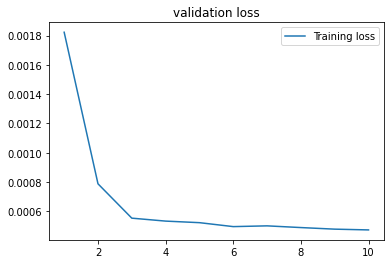

In [ ]:
show_lstm_history(history)

In [ ]:
model_name='LSTM'

# predict test period
prediction = model.predict_generator(test_gen)

In [ ]:
type(prediction)

numpy.ndarray

In [ ]:

import numpy
with numpy.printoptions(threshold=numpy.inf):
    print(prediction)

[[-1.0003533]
 [ 1.2928865]
 [-1.0003533]
 [ 1.2928904]
 [-1.000354 ]
 [ 1.292894 ]
 [-1.0003546]
 [ 1.2928975]
 [-1.000356 ]
 [ 1.2929006]
 [-1.000357 ]
 [ 1.2929046]
 [-1.000357 ]
 [ 1.2929088]
 [-1.000357 ]
 [ 1.2929118]
 [-1.0003582]
 [ 1.2929153]
 [-1.0003588]
 [ 1.2929196]
 [-1.0003597]
 [ 1.2929229]
 [-1.00036  ]
 [ 1.2929265]
 [-1.0003612]
 [ 1.2929305]
 [-1.0003616]
 [ 1.2929342]
 [-1.0003618]
 [ 1.2929374]
 [-1.0003628]
 [ 1.2929406]
 [-1.0003636]
 [ 1.2929446]
 [-1.0003643]
 [ 1.292946 ]
 [-1.0003649]
 [ 1.2929522]
 [-1.0003651]
 [ 1.2929561]
 [-1.0003661]
 [ 1.2929596]
 [-1.0003664]
 [ 1.2929633]
 [-1.0003675]
 [ 1.2929666]
 [-1.0003676]
 [ 1.2929701]
 [-1.0003682]
 [ 1.2929695]
 [-1.0003688]
 [ 1.2929786]
 [-1.0003686]
 [ 1.2929827]
 [-1.0003691]
 [ 1.2929851]
 [-1.0003704]
 [ 1.2929885]
 [-1.0003709]
 [ 1.2929926]
 [-1.0003719]
 [ 1.2929958]
 [-1.0003724]
 [ 1.2929991]
 [-1.0003728]
 [ 1.2930012]
 [-1.0003732]
 [ 1.2930074]
 [-1.0003734]
 [ 1.2930199]
 [-1.0003748]
 [ 1.2

In [ ]:
'''

predictions, mse = evaluate_arima_model(train_data['Price'], test_data['Price'],(2, 1, 1))
df_pred = pd.DataFrame({'Price':predictions},index=test_data.index)
'''

In [ ]:
test_data['LSTM_Predictions'] = prediction

ValueError: ignored